<a href="https://colab.research.google.com/github/Mary-prh/MNIST_Dense_Model_TensorFlow/blob/main/MNIST_MultiClass_Classification_DenseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-10fe6cc0-c089-a522-dbed-22361f62bbf9)


In [3]:
import tensorflow as tf
import numpy as np

In [4]:
print(tf.__version__)

2.8.2


# **Load Data**

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


# **Explore Data**

In [7]:
x_train.shape , y_train.shape , len(x_train)

((60000, 28, 28), (60000,), 60000)

In [8]:
x_test.shape , y_test.shape , len(x_test)

((10000, 28, 28), (10000,), 10000)

In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# How many classes are there (this'll be our output shape)?
len(class_names)

10

In [10]:
def random_visualization(data, label):
  import random
  import matplotlib.pyplot as plt
  random_index = random.choice(range(len(data)))
  plt.imshow(data[random_index])
  plt.title(class_names[label[random_index]])

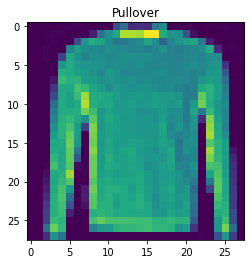

In [11]:
random_visualization(x_test, y_test) 

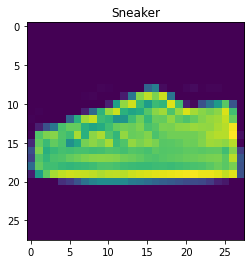

In [12]:
random_visualization(x_train, y_train)

# **Preprocessing**

## **Option 1: Normalization only**

In [13]:
x_train.min() , x_train.max()

(0, 255)

In [14]:
# X_train = x_train.astype('float32') / 255
# X_test =  x_test.astype('float32') / 255

## **Option 2: Data Augmentation Including Normalization**

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***ImageDataGenerator takes in tensors with 4 dimentiones. So, we add another dimention to the training and test sets***

In [16]:
X_train = tf.expand_dims(x_train, axis= -1)
X_test = tf.expand_dims(x_test, axis= -1)
X_train.shape , X_test.shape , len(X_train)

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]), 60000)

In [17]:
datagen = ImageDataGenerator(rescale= 1./255 , shear_range= 0.2, 
                             zoom_range = 0.2, 
                             horizontal_flip = True, dtype = 'float32')

In [18]:
datagen.fit(X_train)

In [19]:
train_data = datagen.flow(x= X_train , y= y_train , batch_size= 32, seed = 42)

In [20]:
validation_data = datagen.flow(x= X_test , y= y_test , batch_size= 8, seed=42)

In [21]:
train_data 

# **Create Model**

## **Model 1**

### **Callbacks**

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 5)

In [23]:
checkpoint_path = 'model_checkpoints/cp_1.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, 
                                                      monitor= 'val_loss', save_weights_only= True,
                                                      save_best_only= True)

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, 
                                                 patience = 5, min_lr = 1e-7)

In [25]:
# traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) 

### **create, compile, fit**

***The `Flatten` layer is required for NON-CNN models***

In [26]:
tf.random.set_seed(42)

model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation= 'relu'),
    tf.keras.layers.Dense(70, activation= 'relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dense(len(class_names), activation= 'softmax')
])

In [27]:
model_1.compile(tf.keras.optimizers.Adam(learning_rate= 0.001), 
                loss= tf.keras.losses.SparseCategoricalCrossentropy(), 
                metrics = ['accuracy'])

In [28]:
history_1 = model_1.fit(train_data, epochs= 100, 
            validation_data = validation_data, batch_size = 32, 
            steps_per_epoch = len(X_train) / 32, 
            callbacks = [early_stopping , model_checkpoint , reduce_lr])

Epoch 1/100
1875/1875 [==============================] - 23s 12ms/step - loss: 0.6833 - accuracy: 0.7501 - val_loss: 0.5728 - val_accuracy: 0.7916 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 23s 12ms/step - loss: 0.5300 - accuracy: 0.8020 - val_loss: 0.5351 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4896 - accuracy: 0.8181 - val_loss: 0.4922 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4705 - accuracy: 0.8236 - val_loss: 0.5014 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4502 - accuracy: 0.8309 - val_loss: 0.4693 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 6/100
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4407 - accuracy: 0.8343 - val_loss: 0.4701 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 7/100
1875/1875 [=================

### **Evaluation**

***To make prediction with the test set, there are some steps of processing to match the test set with the training level. (The data generation level should not be applied to the prediction level. So, we should not use this step as the prediction). The levels include `normalization` and changing the dtype to `float32`.***

In [33]:
evaluation_set = x_test.astype('float32') / 255

*Because we made the input 3D images:*

*Because we generated batches:*

In [30]:
# evaluation_set = tf.expand_dims(evaluation_set, axis= 0)

In [34]:
evaluation_set.shape

(10000, 28, 28)

In [55]:
predsProb_1 = model_1.predict(tf.expand_dims(evaluation_set, axis=-1) )

In [56]:
predsProb_1.shape

(10000, 10)

In [57]:
predsProb_1

array([[8.2472138e-07, 1.5526890e-12, 3.1510336e-07, ..., 1.0024065e-02,
        9.8694741e-09, 9.8849434e-01],
       [1.5676842e-04, 1.3136776e-13, 9.9849093e-01, ..., 3.3583410e-34,
        6.3519388e-13, 2.9595965e-30],
       [4.8776729e-09, 9.9999988e-01, 9.7742365e-09, ..., 0.0000000e+00,
        1.5778551e-07, 7.7066859e-21],
       ...,
       [1.0249957e-08, 7.9515255e-16, 1.1239858e-10, ..., 1.7909182e-13,
        1.0000000e+00, 6.3617137e-19],
       [1.2819431e-11, 1.0000000e+00, 2.6393809e-12, ..., 0.0000000e+00,
        6.8959118e-12, 2.5126063e-25],
       [5.2001599e-08, 7.0678223e-13, 3.6157860e-07, ..., 3.7935276e-03,
        1.1193991e-06, 6.0944867e-06]], dtype=float32)

In [58]:
preds_1 = tf.argmax(predsProb_1, axis=1)
preds_1

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([9, 2, 1, ..., 8, 1, 5])>

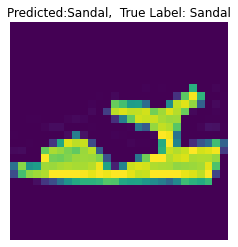

In [64]:
import matplotlib.pyplot as plt
import random

indx = random.choice(range(len(x_test)))
plt.imshow(x_test[indx])
plt.title(f"Predicted:{class_names[preds_1[indx]]},  True Label: {class_names[y_test[indx]]}")
plt.axis(False);

In [65]:
result_1 = model_1.evaluate(validation_data)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.4114 - accuracy: 0.8460


### **Result Visualization**

In [40]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
 dense_2 (Dense)             (None, 50)                3550      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 89,630
Trainable params: 89,630
Non-trainable params: 0
_________________________________________________________________


In [41]:
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
hist_1 = pd.DataFrame(history_1.history)
hist_1

,loss,accuracy,val_loss,val_accuracy,lr
0,0.683295,0.750100,0.572797,0.7916,0.001
1,0.529971,0.801967,0.535091,0.8011,0.001
2,0.489645,0.818067,0.492246,0.8165,0.001
3,0.470458,0.823600,0.501435,0.8108,0.001
4,0.450221,0.830867,0.469299,0.8262,0.001
5,0.440681,0.834317,0.470119,0.8193,0.001
6,0.428679,0.838400,0.458840,0.8256,0.001
7,0.418364,0.842850,0.455604,0.8238,0.001
8,0.413287,0.842750,0.435931,0.8402,0.001
9,0.405427,0.846583,0.441336,0.8363,0.001


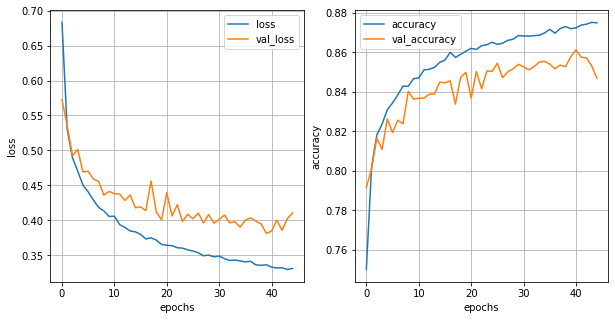

In [51]:
ax = plt.subplots(1,2, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist_1[['loss', 'val_loss']])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(['loss', 'val_loss'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_1[['accuracy', 'val_accuracy']])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

### **Load Weights**

*The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron in the selected layer (our selected layer has 100 neurons).*

*Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.*

*These values start out as random numbers (they're set by the `kernel_initializer` parameter when creating a layer, the default is "`glorot_uniform`") and are then updated to better representative values of the data (non-random) by the neural network during training.*

In [52]:
weights, biases = model_1.layers[1].get_weights()
weights, weights.shape

(array([[-0.22980057, -0.59555364, -0.15269727, ...,  0.33931386,
         -0.12121668, -0.12982517],
        [-0.19850089, -0.7033435 ,  0.17561775, ...,  0.48420998,
         -0.11378071, -0.16974515],
        [-0.09058047, -0.68863255,  0.15852953, ...,  0.51027876,
         -0.0381098 , -0.15436241],
        ...,
        [ 0.03300975, -0.41498697,  0.8951098 , ...,  0.03450249,
          0.39504978,  0.259309  ],
        [ 0.07688038, -0.2850016 ,  0.4677993 , ...,  0.05554866,
         -0.07668812, -0.03311103],
        [ 0.24857554, -0.07774154, -0.4559085 , ..., -0.01304947,
         -0.4265334 , -0.00641484]], dtype=float32), (784, 100))

*Every neuron has a bias vector. Each of these is paired with a weight matrix.*

*The bias values get initialized as zeroes by default (using the bias_initializer parameter).*

*The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.*

In [53]:
biases, biases.shape

(array([ 0.52429956,  0.6044806 , -0.13731046, -0.38998774,  0.2029339 ,
         0.01126651, -0.8981315 , -1.0143359 ,  0.15137823, -0.01363268,
         0.25976837,  0.8805337 , -0.30215466,  0.40945786, -1.1124817 ,
        -0.03515433,  0.52064466,  0.4966915 ,  0.27671486, -0.21198042,
        -0.43691966, -0.0462205 , -1.0937105 ,  0.2765916 ,  1.2105479 ,
         1.037636  ,  0.2193548 ,  1.3581778 , -0.11455015,  0.04292421,
         0.19908354, -0.01609655, -0.05198875, -1.1282214 ,  0.40186206,
         0.7981012 ,  0.23474807,  0.26240358, -0.7348106 , -0.9721502 ,
        -0.7630324 ,  0.05749689,  0.6327955 ,  0.31712976,  0.30303293,
         1.074337  , -0.7032213 ,  0.2593641 ,  0.07771207, -0.03670844,
        -0.11066703,  0.17647775,  0.47781917,  0.9008833 ,  0.16567588,
        -0.074083  ,  0.74433076,  0.357506  ,  0.23666292,  0.30626357,
         0.926815  , -0.01088614,  0.05211897, -1.0034288 ,  0.86894983,
         0.16976812, -0.01743165,  0.47985166, -0.6

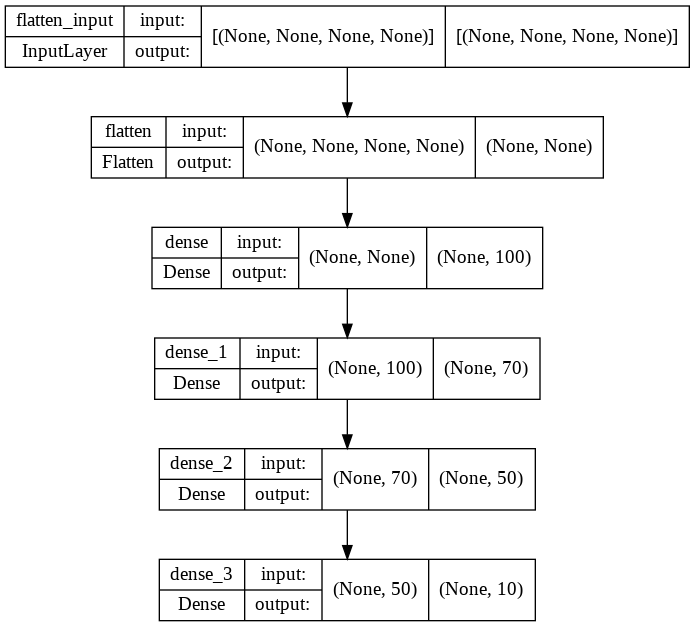

In [54]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, show_shapes=True)